# Correlations in cloud variables

- increase in lts
- correlation lts-tqc
- better correlations with 

In [1]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import pandas as pd
import file_handling as fh
import postprocessing as pp
import calculations as cc
import xarray as xr
fh.disable_warnings()

import matplotlib.pyplot as plt
import plot_utils as pu

Any code that generates warnings will no longer print them to the console.


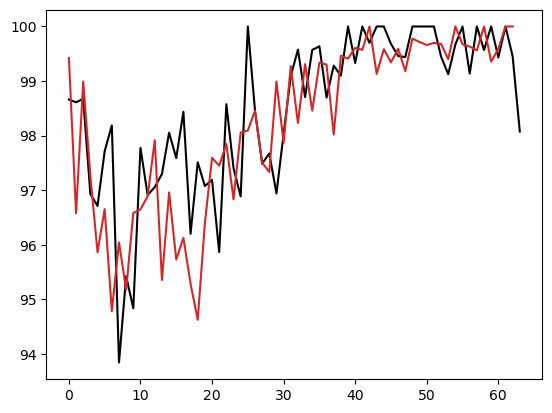

In [2]:
def load_proprocessed_data(save_dir='/scratch/m/m300872/temp/metrics', nsamples=5000):
    data = dict()
    for experiment in ['ctrl', 'warm']:
        file_list = list()
        chunks = [20*x for x in range(11)]
        for i in range(len(chunks)-1):
            filename = f'{experiment}_{chunks[i]}-{chunks[i+1]}_n{nsamples}.nc'
            filename = os.path.join(save_dir, filename)
            file_list.append(filename)
        data[experiment] = xr.open_mfdataset(file_list, combine = 'nested', concat_dim="time")
    return data

var = 'albedo'
var = 'clct'
data = load_proprocessed_data()
fig, ax = plt.subplots()
ax.plot(data['ctrl'][var].mean(dim='cell', keep_attrs=True), color='black')
ax.plot(data['warm'][var].mean(dim='cell', keep_attrs=True), color='tab:red')
fig.show()

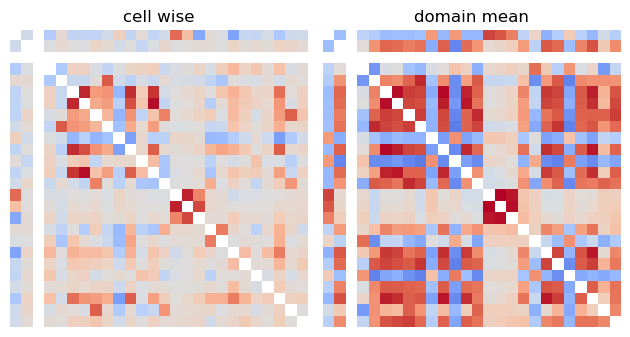

In [3]:
def load_proprocessed_data(save_dir='/scratch/m/m300872/temp/metrics', nsamples=5000):
    data = dict()
    for experiment in ['ctrl', 'warm']:
        file_list = list()
        chunks = [20*x for x in range(11)]
        for i in range(len(chunks)-1):
            filename = f'{experiment}_{chunks[i]}-{chunks[i+1]}_n{nsamples}.nc'
            filename = os.path.join(save_dir, filename)
            file_list.append(filename)
        data[experiment] = xr.open_mfdataset(file_list, combine = 'nested', concat_dim="time")
    return data

data = load_proprocessed_data()
fig, axs = plt.subplots(1,2)
ax = axs[0]
for ax, dataset, label in zip(axs, [data['ctrl'], data['ctrl'].mean(dim='cell')], ['cell wise', 'domain mean']):
    d = pp.remove_dimension(dataset, 'height')
    ax = pu.ax_correlation_matrix(ax, d, annotate_values=False, add_cbar=False)
    ax.set_title(label)
    ax = pu.remove_spines(ax, ['left', 'right', 'top', 'bottom'])
    ax = pu.remove_ticks(ax, ['left', 'right', 'top', 'bottom'])
fig.tight_layout()
fig.show()

In [4]:
# stop()

In [5]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import pandas as pd
import file_handling as fh
import postprocessing as pp
import calculations as cc
import xarray as xr
fh.disable_warnings()

def load_warm(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/', file_slice=slice(None)):
    datasets = list()

    file_list = fh.disk_data_from_keywords(exp_dir, ['3D', 'DOM01'], return_file_list=1)
    # limit upper bound of file_slice
    file_slice = slice(file_slice.start, 
                       min(file_slice.stop, len(file_list)) if file_slice.stop is not None else len(file_list), 
                       file_slice.step)
    file_list = file_list[file_slice]
    
    data = xr.open_mfdataset(file_list, combine = 'nested', concat_dim="time")
    data = pp.clean_volume_data(data)
    data = data.sel(time=~pd.Index(data['time']).duplicated())
    datasets.append(data)
    
    file_list = fh.disk_data_from_keywords(exp_dir, ['radiation', 'DOM01'], return_file_list=1)
    data = xr.open_mfdataset(file_list, combine = 'nested', concat_dim="time")
    data = pp.clean_surface_data(data)
    data = data.sel(time=~pd.Index(data['time']).duplicated())
    datasets.append(data)
    
    file_list = fh.disk_data_from_keywords(exp_dir, ['surface', 'DOM01'], return_file_list=1)
    data = xr.open_mfdataset(file_list, combine = 'nested', concat_dim="time")
    data = pp.clean_surface_data(data)
    data = data.sel(time=~pd.Index(data['time']).duplicated())
    datasets.append(data)
    
    datasets = pp.time_overlap(datasets)
    data = xr.merge(datasets)
    return data

def load_ctrl():
    datasets = [fh.eureca_data_from_keywords(['3D', 'DOM01']), fh.eureca_data_from_keywords(['surface', 'DOM01']), fh.eureca_data_from_keywords(['radiation', 'DOM01'])]
    datasets = pp.time_overlap(datasets)
    data = xr.merge(datasets)
    # data, warm = pp.time_overlap([data, warm])
    return data

def subsample(data, ncells=1000):
    data = pp.filter_by_threshold(data, {'tqi_dia':1e-4}, below_threshold=True, chunk_size=None)
    data = pp.filter_by_threshold(data, {'tqc_dia':1e-1}, below_threshold=False, chunk_size=None)
    data = pp.random_subsample(data, {'cell':ncells}).squeeze()
    data = calculate_metrics(data, drop_vars=False)
    data = pp.filter_by_threshold(data, {'cth':11}, below_threshold=False, chunk_size=None)
    return data

def calculate_metrics(data, drop_vars=True):
    data_vars = list(data)
    data = pp.replace_height_indices_with_values(data)
    data = cc.add_lifting_condensation_level_pressure(data)
    data = cc.add_lower_tropospheric_stability(data)
    data = cc.add_estimated_lapse_rate_stability(data)
    data = cc.add_cloud_top_height(data)
    data = pp.add_arithmetic_variable(data, 'sob_t', 'sod_t', '/', 'albedo')
    data = data.compute()
    data['eis'] = data['lts'] - data['elrs']
    data['eis'].attrs['long_name'] = 'estimated inversion strenght'
    if drop_vars: data = data.drop_vars(data_vars)
    return data

save_dir = '/scratch/m/m300872/temp/metrics'
nsamples = 1000

chunks = [20*x for x in range(11)]
for i in range(len(chunks)-1):
    print(slice(chunks[i],chunks[i+1]), end=' ')
    if os.path.exists(os.path.join(save_dir, f'ctrl_{chunks[i]}-{chunks[i+1]}_n{nsamples}.nc')) and os.path.exists(os.path.join(save_dir, f'warm_{chunks[i]}-{chunks[i+1]}_n{nsamples}.nc')):
        print('exists')
    else:
        warm = load_warm(file_slice=slice(chunks[i],chunks[i+1]))
        # ctrl = load_ctrl()
        # ctrl, warm = pp.time_overlap([ctrl, warm])
        # ctrl = subsample(ctrl, nsamples)
        warm = subsample(warm, nsamples)
        # ctrl.to_netcdf(os.path.join(save_dir, f'ctrl_{chunks[i]}-{chunks[i+1]}_n{nsamples}.nc'))
        warm.to_netcdf(os.path.join(save_dir, f'warm_{chunks[i]}-{chunks[i+1]}_n{nsamples}.nc'))
        print('done')

Any code that generates warnings will no longer print them to the console.
slice(0, 20, None) exists
slice(20, 40, None) exists
slice(40, 60, None) exists
slice(60, 80, None) exists
slice(80, 100, None) exists
slice(100, 120, None) exists
slice(120, 140, None) exists
slice(140, 160, None) exists
slice(160, 180, None) exists
slice(180, 200, None) exists


In [6]:
file_list = list()
chunks = [20*x for x in range(11)]
for i in range(len(chunks)-1):
    filename = f'ctrl_{chunks[i]}-{chunks[i+1]}_n{nsamples}.nc'
    filename = os.path.join(save_dir, filename)
    file_list.append(filename)
ctrl = xr.open_mfdataset(file_list)

file_list = list()
chunks = [20*x for x in range(11)]
for i in range(len(chunks)-1):
    filename = f'warm_{chunks[i]}-{chunks[i+1]}_n{nsamples}.nc'
    filename = os.path.join(save_dir, filename)
    file_list.append(filename)
warm = xr.open_mfdataset(file_list, combine = 'nested', concat_dim="time")

ctrl

<xarray.Dataset> Size: 252MB
Dimensions:        (time: 64, cell: 1000, height: 68, bnds: 2)
Coordinates:
  * time           (time) datetime64[ns] 512B 2020-01-09T12:00:00 ... 2020-01...
  * height         (height) float32 272B 5.602e+03 5.481e+03 ... 34.78 10.0
  * cell           (cell) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * bnds           (bnds) int64 16B 0 1
Data variables: (12/37)
    cloud_num      (time, cell) float32 256kB dask.array<chunksize=(6, 1000), meta=np.ndarray>
    height_bnds    (time, height, bnds, cell) float64 70MB dask.array<chunksize=(6, 68, 2, 1000), meta=np.ndarray>
    pres           (time, height, cell) float32 17MB dask.array<chunksize=(6, 68, 1000), meta=np.ndarray>
    qc             (time, height, cell) float32 17MB dask.array<chunksize=(6, 68, 1000), meta=np.ndarray>
    qr             (time, height, cell) float32 17MB dask.array<chunksize=(6, 68, 1000), meta=np.ndarray>
    qv             (time, height, cell) float32 17MB dask.array<chunksize=(6, 68, 1000), meta=np.ndarray>
    ...             ...
    lcl_pres       (time, cell) float64 512kB dask.array<chunksize=(6, 1000), meta=np.ndarray>
    lts            (time, cell) float64 512kB dask.array<chunksize=(6, 1000), meta=np.ndarray>
    elrs           (time, cell) float64 512kB dask.array<chunksize=(6, 1000), meta=np.ndarray>
    cth            (time, cell) float64 512kB dask.array<chunksize=(6, 1000), meta=np.ndarray>
    albedo         (time, cell) float32 256kB dask.array<chunksize=(6, 1000), meta=np.ndarray>
    eis            (time, cell) float64 512kB dask.array<chunksize=(6, 1000), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Hauke Schulz (m300408) on l30466 (Linux 4.18.0-305....
    history:              /work/mh0010/m300408/DVC-test/icon-aes/bin/icon at ...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  99
    references:           see MPIM/DWD publications
    source:               icon-nwp\tgit@gitlab.dkrz.de:icon/icon-nwp.git@7e23...
    title:                ICON simulation
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfVGrid:          ecf22d17-dcee-1510-a807-11ae4a612be0

In [7]:
# ctrl = ctrl.mean(dim='cell', keep_attrs=True)
# warm = warm.mean(dim='cell', keep_attrs=True)
# ctrl

In [8]:
print([v for v in list(ctrl) if v not in list(warm)])
print([v for v in list(warm) if v not in list(ctrl)])

['rho', 'theta_v']
['sou_s', 'sob_s', 'thb_s', 'tqi', 'tqs', 'reff_qc']


In [9]:
ctrl = ctrl[[v for v in list(ctrl) if v in list(warm)]]
warm = warm[[v for v in list(warm) if v in list(ctrl)]]

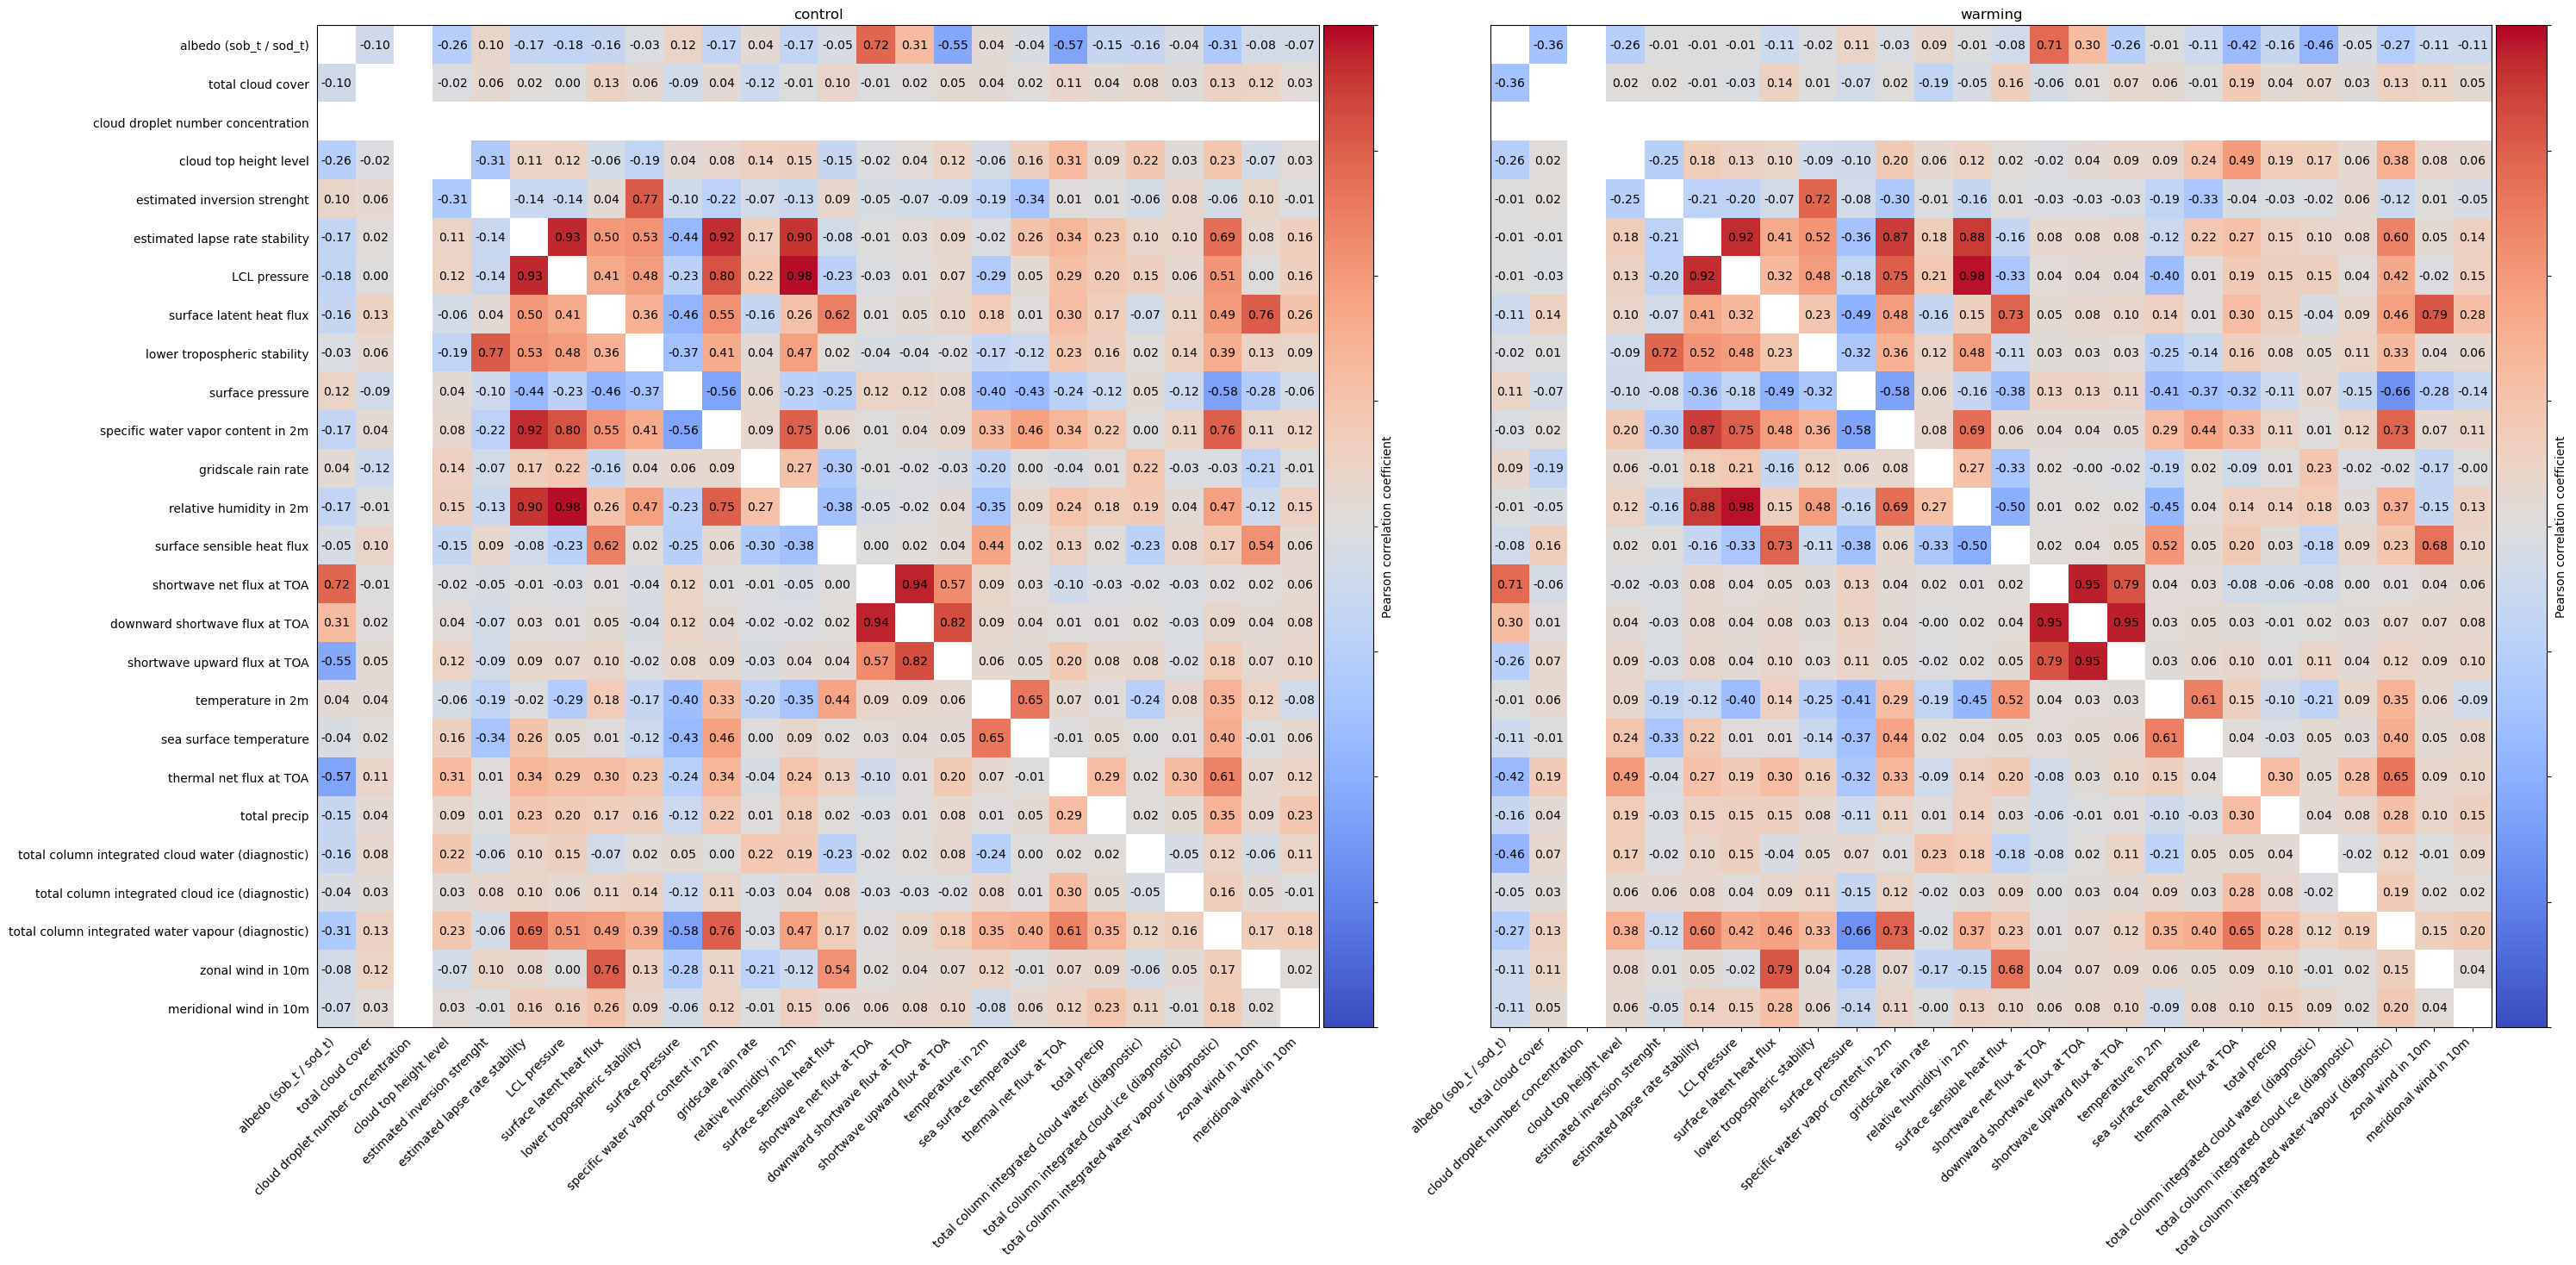

In [10]:
import matplotlib.pyplot as plt
import plot_utils as pu

def remove_dimension(dataset: xr.Dataset, dim_name: str) -> xr.Dataset:
    """
    Remove all variables along a specified dimension from an xarray.Dataset and also remove the dimension itself.

    Parameters:
    ds (xarray.Dataset): The input xarray.Dataset from which variables and the dimension will be removed.
    dim_name (str): The name of the dimension to be removed along with all variables associated with it.

    Returns:
    xarray.Dataset: A new xarray.Dataset with the specified dimension and its associated variables removed.
    """
    vars_to_remove = [var for var in dataset.data_vars if dim_name in dataset[var].dims]
    dataset = dataset.drop_vars(vars_to_remove)
    dataset = dataset.drop_dims(dim_name)
    return dataset
    
# variables = ['lts', 'eis', 'rh_2m', 'lcl_pres', 'cth', 't_2m']

fig, axs = plt.subplots(1,2, figsize=(30,15))
ax =axs[0]
for ax, dataset, label in zip(axs, [ctrl, warm], ['control', 'warming']):
    d = remove_dimension(dataset, 'height')
    ax = pu.ax_correlation_matrix(ax, d)#[variables])
    ax.set_title(label)
ax = pu.remove_ticks(ax, ['left', 'right'])
fig.tight_layout()
fig.show()

In [11]:
# variables = ['rh_2m', 'lcl_pres']
# fig, ax = plt.subplots()
# for data, kwargs in zip([ctrl, warm], [{'color':'black'}, {'color':'red'}]):
#     ax = pu.ax_variable_correlation(ax, data, variables, kwargs=kwargs)
# fig.show()

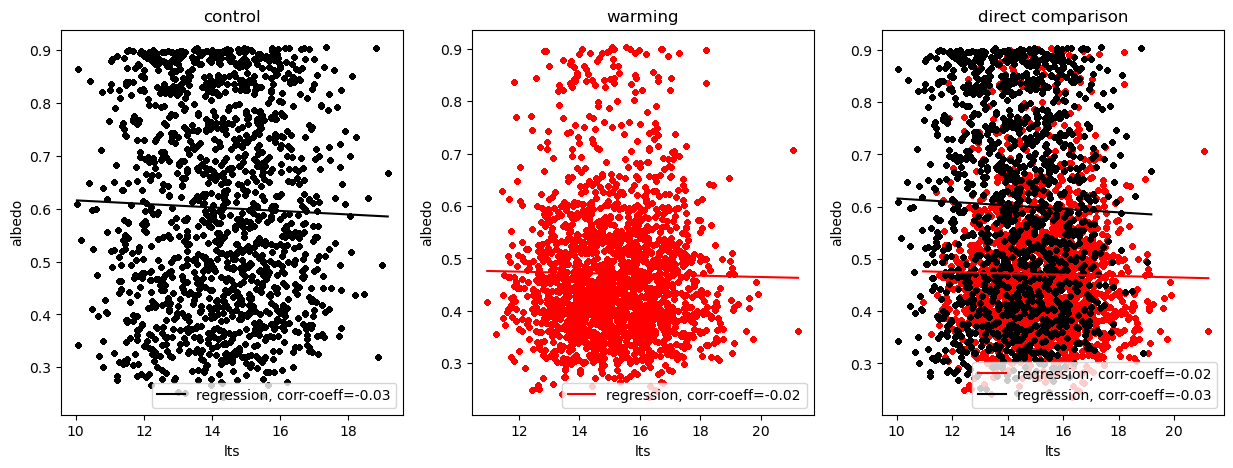

In [12]:
import matplotlib.pyplot as plt
import plot_utils as pu

def regression_plot(variables):
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    for ax, data, title, kwargs in zip(axs, [ctrl, warm, warm], ['control', 'warming', 'direct comparison'], [{'color':'black'}, {'color':'red'}, {'color':'red'}]):
        ax = pu.ax_variable_correlation(ax, data, variables, kwargs=kwargs)
        ax.set_title(title)
    ax = pu.ax_variable_correlation(ax, ctrl, variables, kwargs={'color':'black'})
    fig.show()

variables = ['lts', 'albedo']
regression_plot(variables)

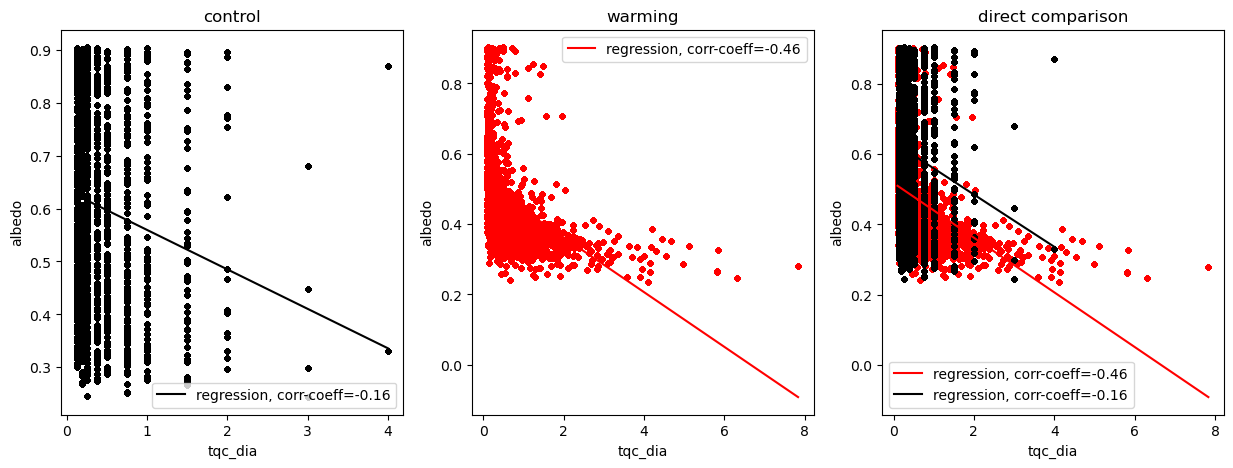

In [13]:
regression_plot(['tqc_dia', 'albedo'])

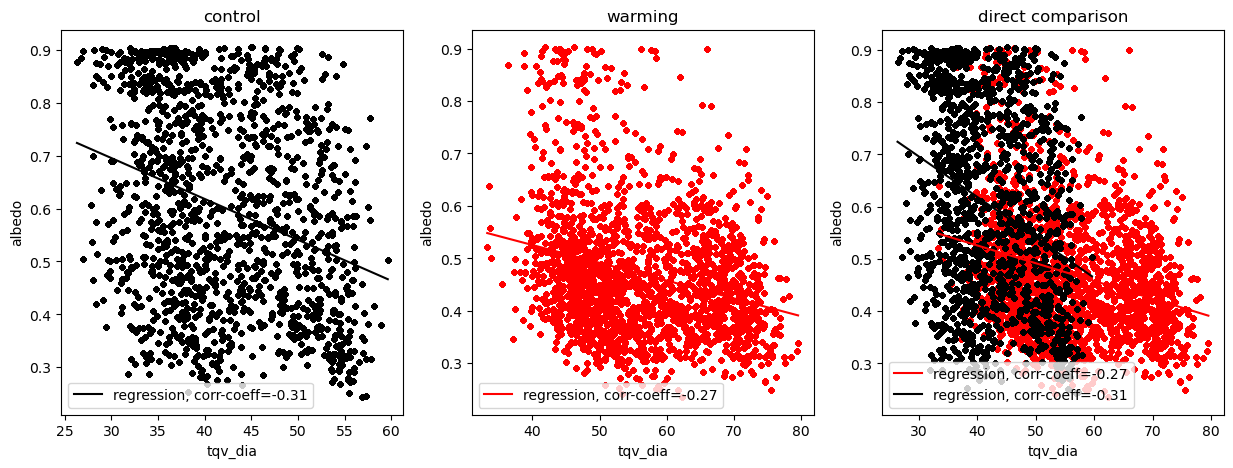

In [14]:
regression_plot(['tqv_dia', 'albedo'])

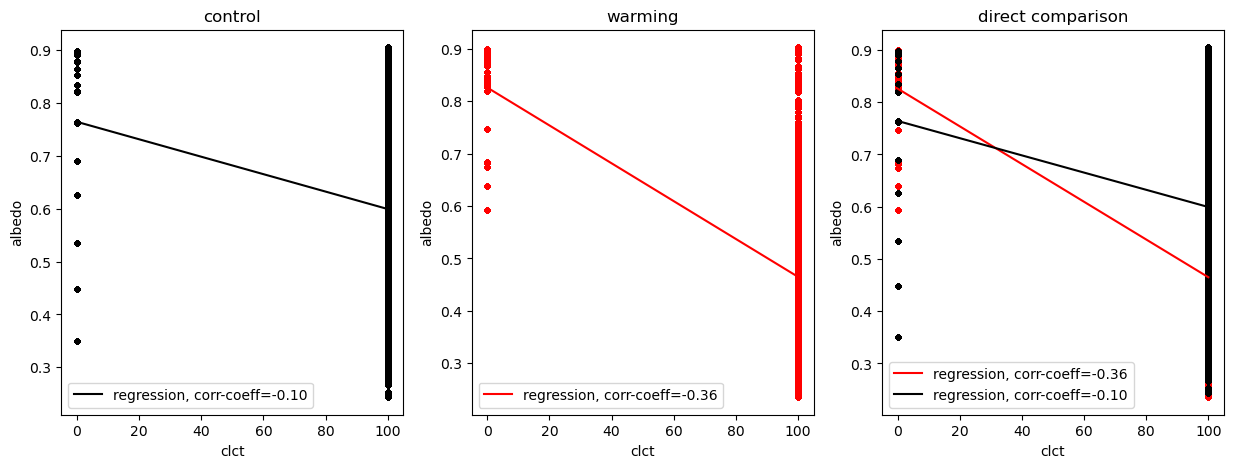

In [15]:
regression_plot(['clct', 'albedo'])

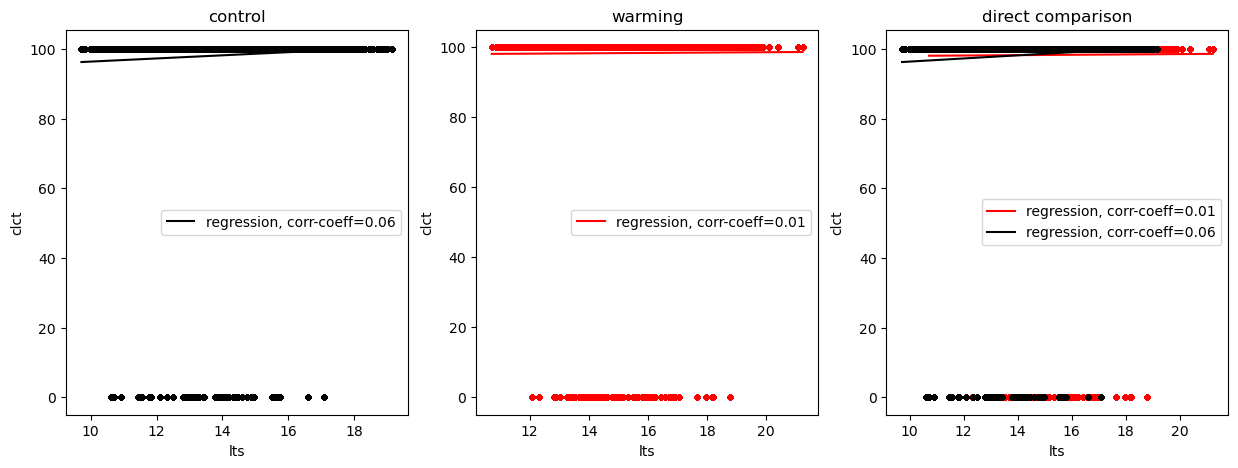

In [16]:
regression_plot(['lts', 'clct'])

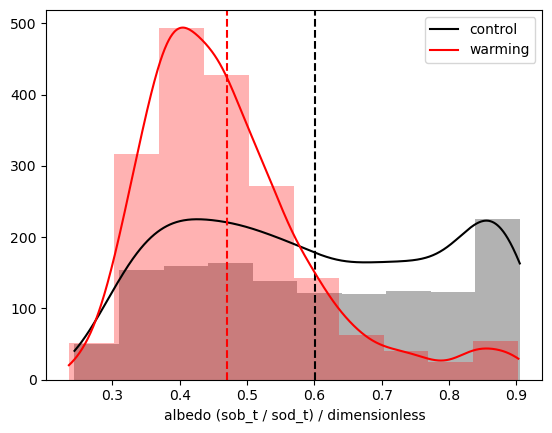

In [17]:
import numpy as np
import importlib; importlib.reload(pu)

def plot_hist_comparison(var):
    fig, ax = plt.subplots()
    kwargs = [ {'label': 'control', 'color': 'black'},
               {'label': 'warming', 'color': 'red'} ]
    for dataset, kws in zip([ctrl, warm], kwargs):
        ax = pu.ax_histogram(ax, dataset, var, **kws)
    fig.show()

plot_hist_comparison('albedo')

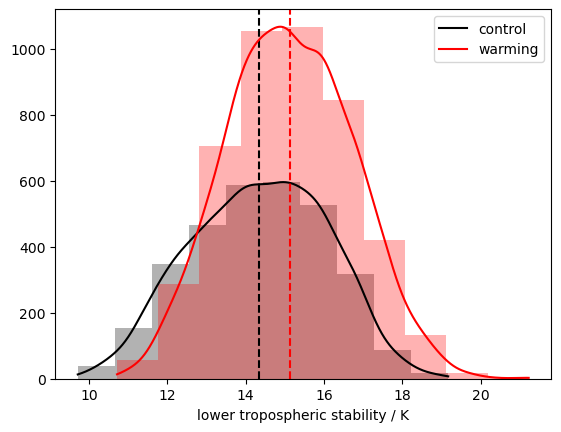

In [18]:
plot_hist_comparison('lts')

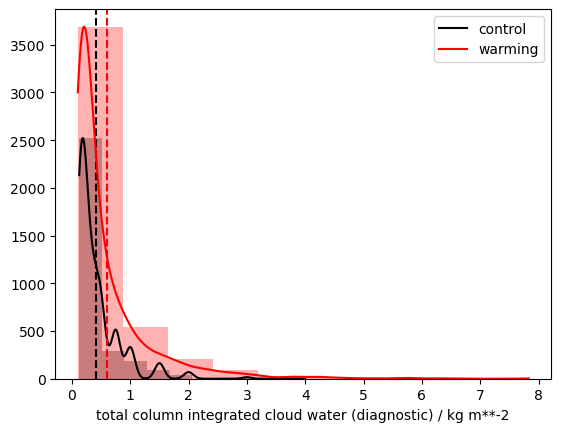

In [19]:
plot_hist_comparison('tqc_dia')

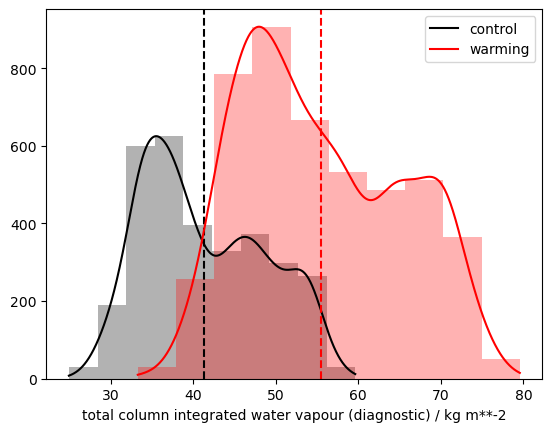

In [20]:
plot_hist_comparison('tqv_dia')

In [21]:
ctrl = ctrl.mean(dim='cell', keep_attrs=True)
warm = warm.mean(dim='cell', keep_attrs=True)
ctrl

<xarray.Dataset> Size: 218kB
Dimensions:        (time: 64, height: 68, bnds: 2)
Coordinates:
  * time           (time) datetime64[ns] 512B 2020-01-09T12:00:00 ... 2020-01...
  * height         (height) float32 272B 5.602e+03 5.481e+03 ... 34.78 10.0
  * bnds           (bnds) int64 16B 0 1
Data variables: (12/35)
    cloud_num      (time) float32 256B dask.array<chunksize=(6,), meta=np.ndarray>
    height_bnds    (time, height, bnds) float64 70kB dask.array<chunksize=(6, 68, 2), meta=np.ndarray>
    pres           (time, height) float32 17kB dask.array<chunksize=(6, 68), meta=np.ndarray>
    qc             (time, height) float32 17kB dask.array<chunksize=(6, 68), meta=np.ndarray>
    qr             (time, height) float32 17kB dask.array<chunksize=(6, 68), meta=np.ndarray>
    qv             (time, height) float32 17kB dask.array<chunksize=(6, 68), meta=np.ndarray>
    ...             ...
    lcl_pres       (time) float64 512B dask.array<chunksize=(6,), meta=np.ndarray>
    lts            (time) float64 512B dask.array<chunksize=(6,), meta=np.ndarray>
    elrs           (time) float64 512B dask.array<chunksize=(6,), meta=np.ndarray>
    cth            (time) float64 512B dask.array<chunksize=(6,), meta=np.ndarray>
    albedo         (time) float32 256B dask.array<chunksize=(6,), meta=np.ndarray>
    eis            (time) float64 512B dask.array<chunksize=(6,), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Hauke Schulz (m300408) on l30466 (Linux 4.18.0-305....
    history:              /work/mh0010/m300408/DVC-test/icon-aes/bin/icon at ...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  99
    references:           see MPIM/DWD publications
    source:               icon-nwp\tgit@gitlab.dkrz.de:icon/icon-nwp.git@7e23...
    title:                ICON simulation
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfVGrid:          ecf22d17-dcee-1510-a807-11ae4a612be0

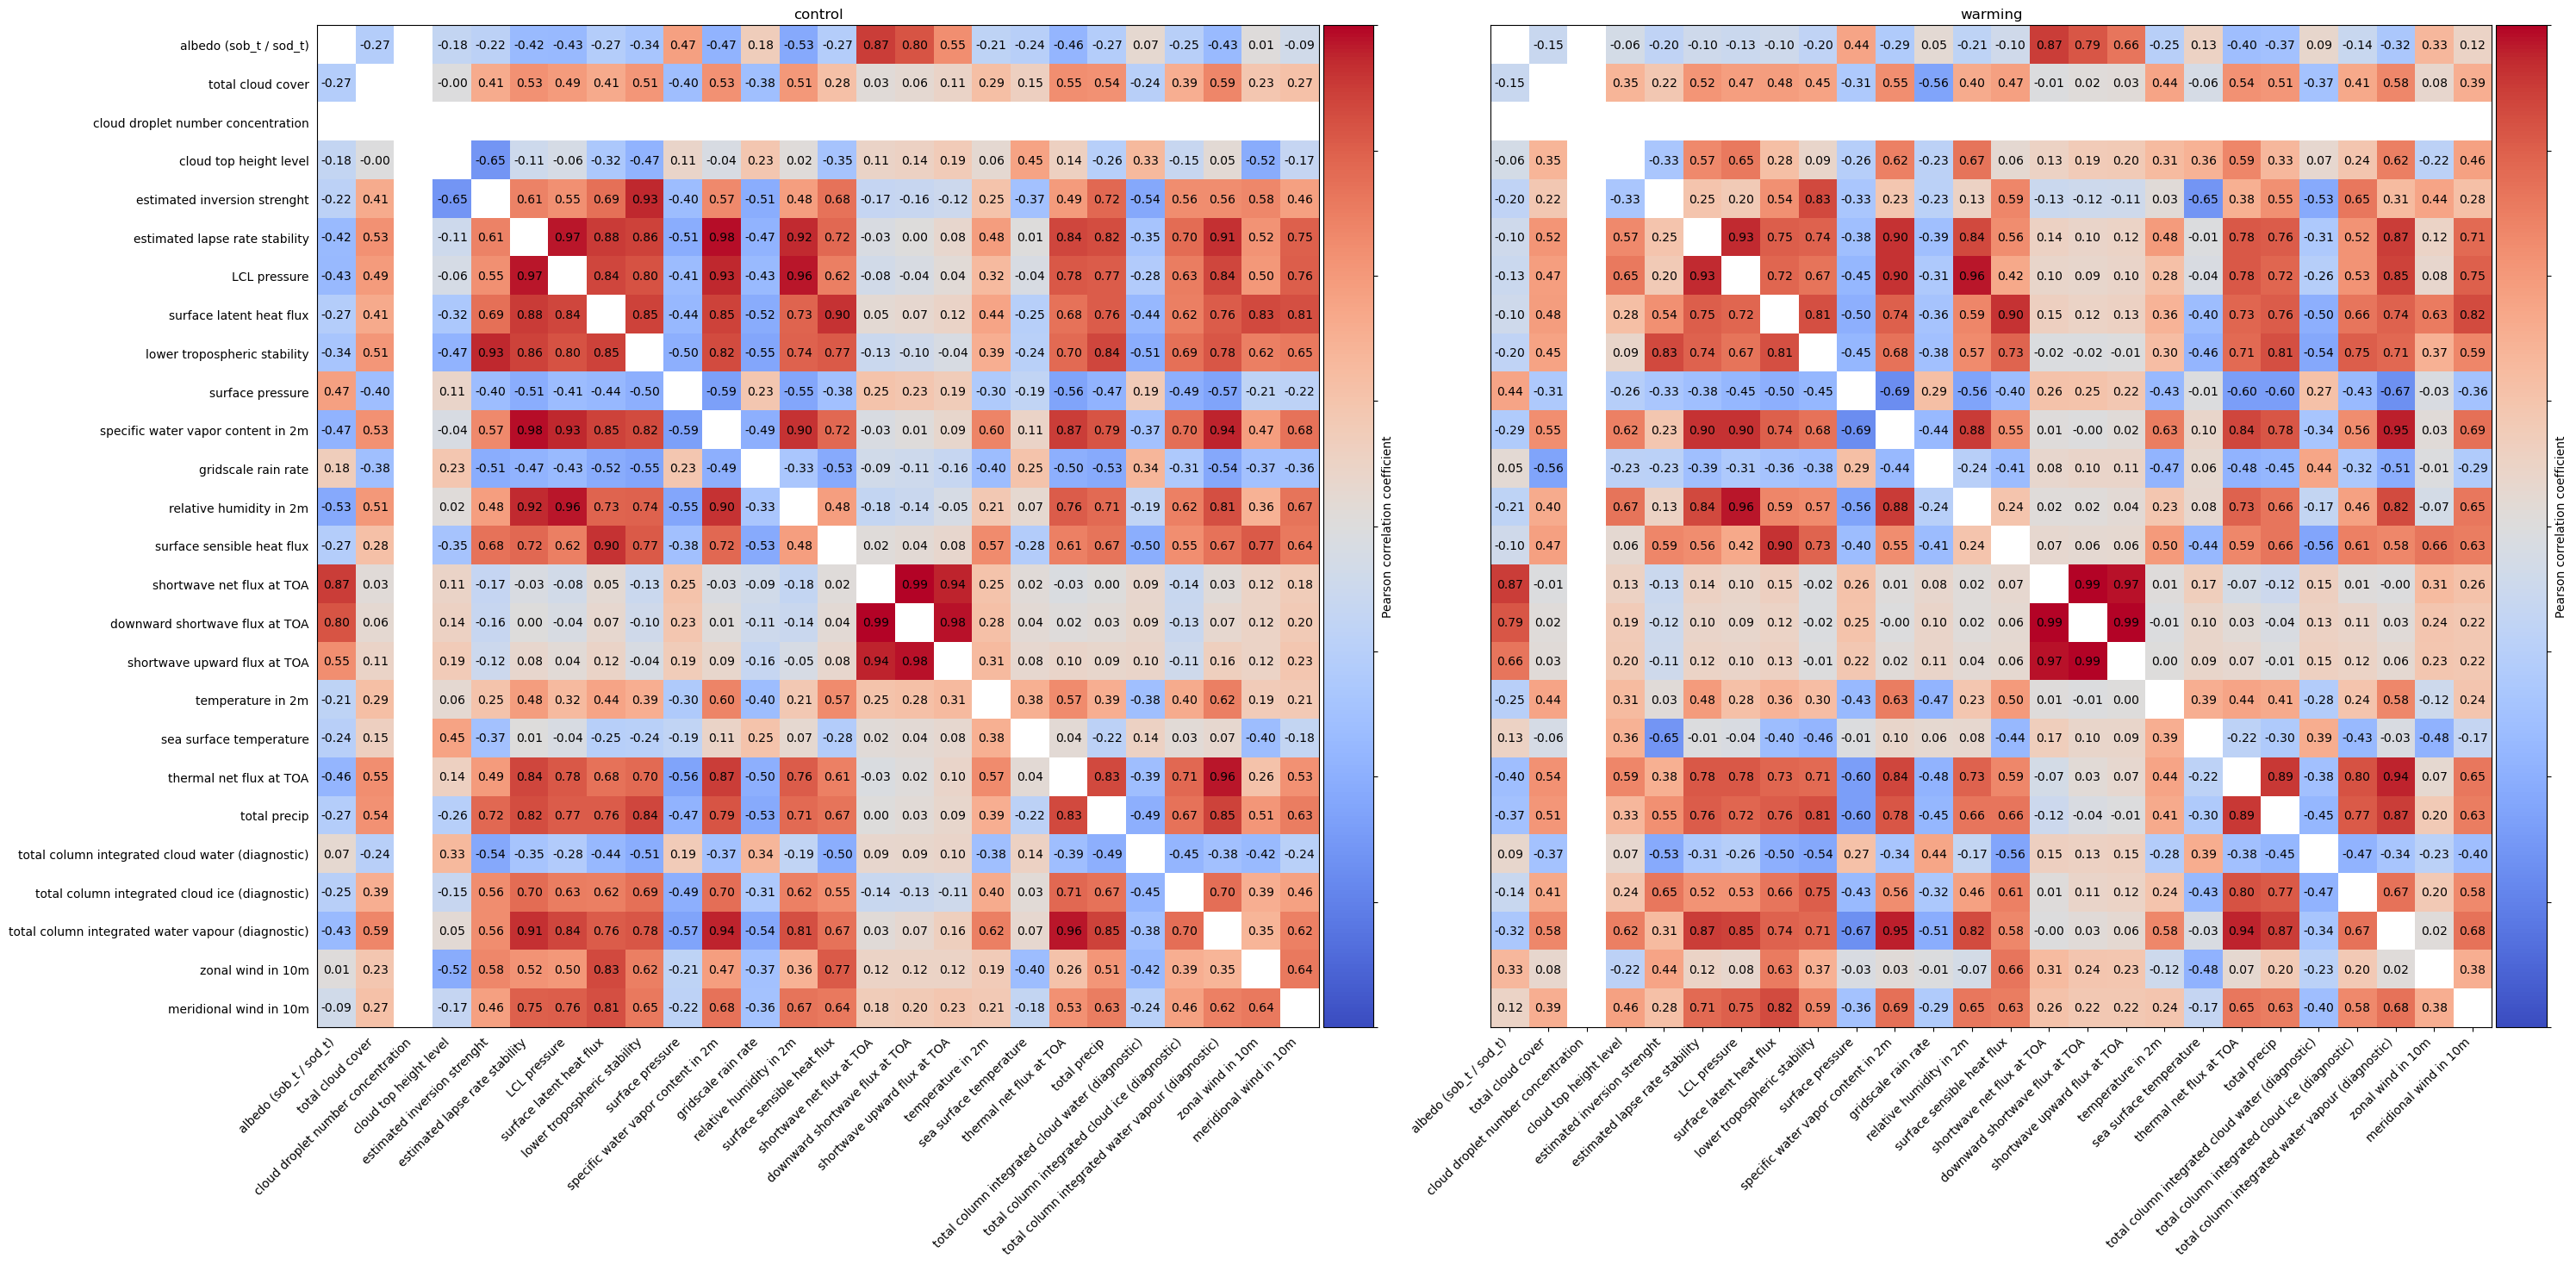

In [22]:
fig, axs = plt.subplots(1,2, figsize=(30,15))
ax =axs[0]
for ax, dataset, label in zip(axs, [ctrl, warm], ['control', 'warming']):
    d = remove_dimension(dataset, 'height')
    ax = pu.ax_correlation_matrix(ax, d)#[variables])
    ax.set_title(label)
ax = pu.remove_ticks(ax, ['left', 'right'])
fig.tight_layout()
fig.show()

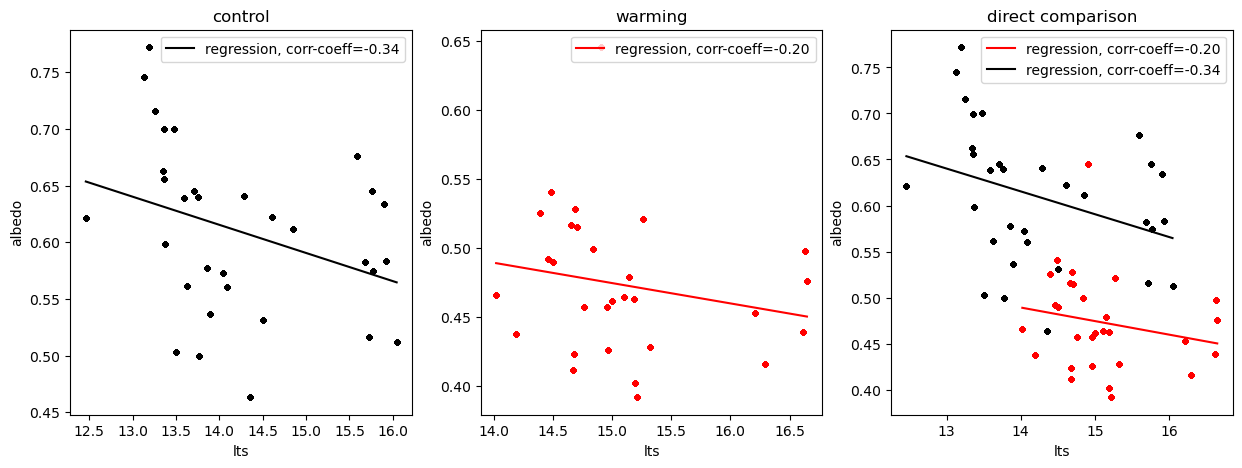

In [23]:
regression_plot(['lts', 'albedo'])

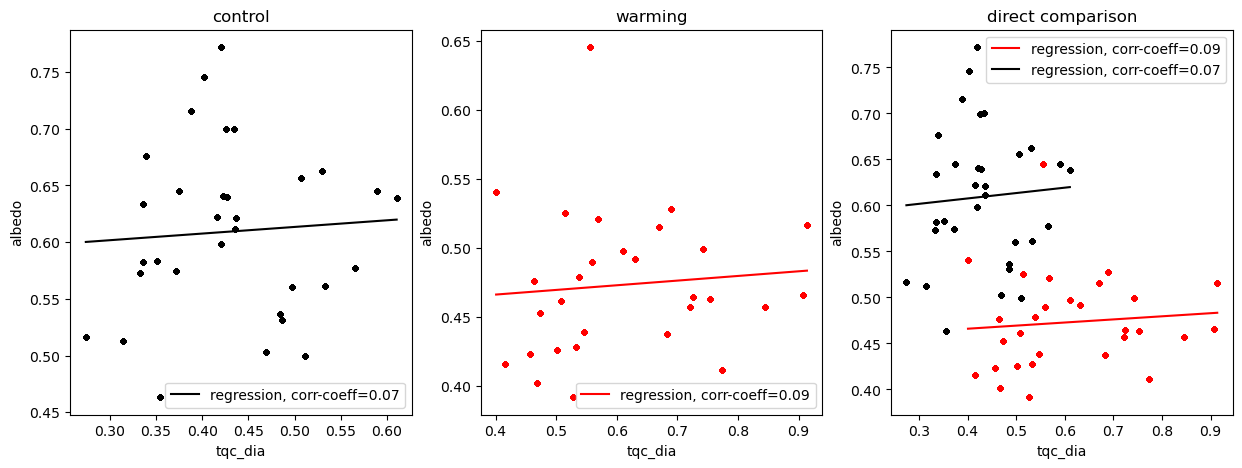

In [24]:
regression_plot(['tqc_dia', 'albedo'])

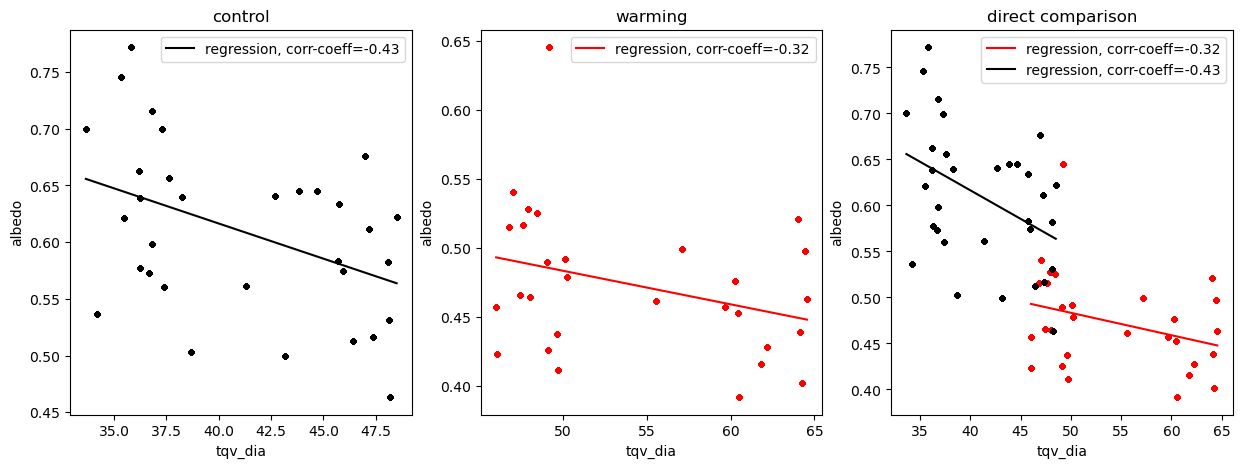

In [25]:
regression_plot(['tqv_dia', 'albedo'])

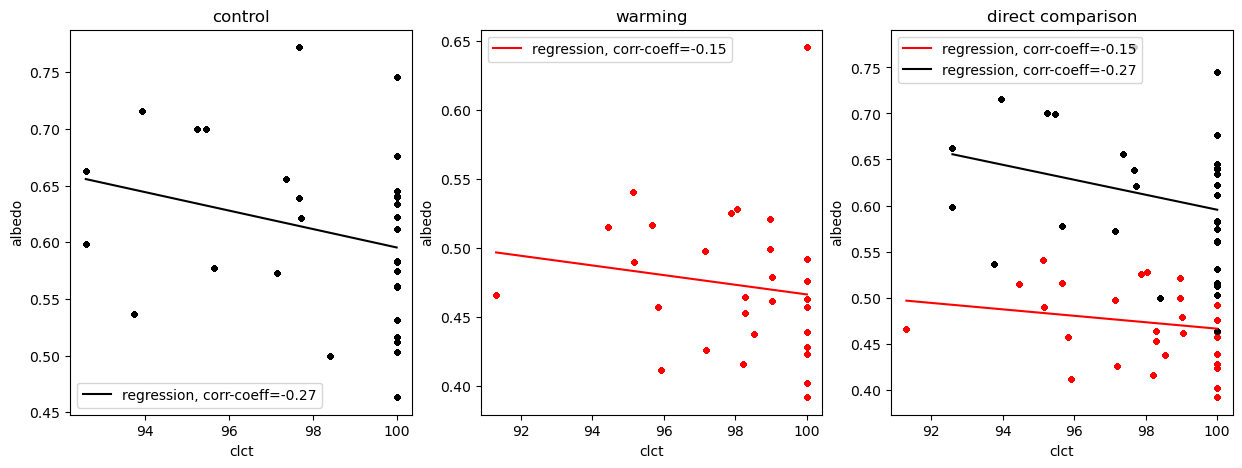

In [26]:
regression_plot(['clct', 'albedo'])

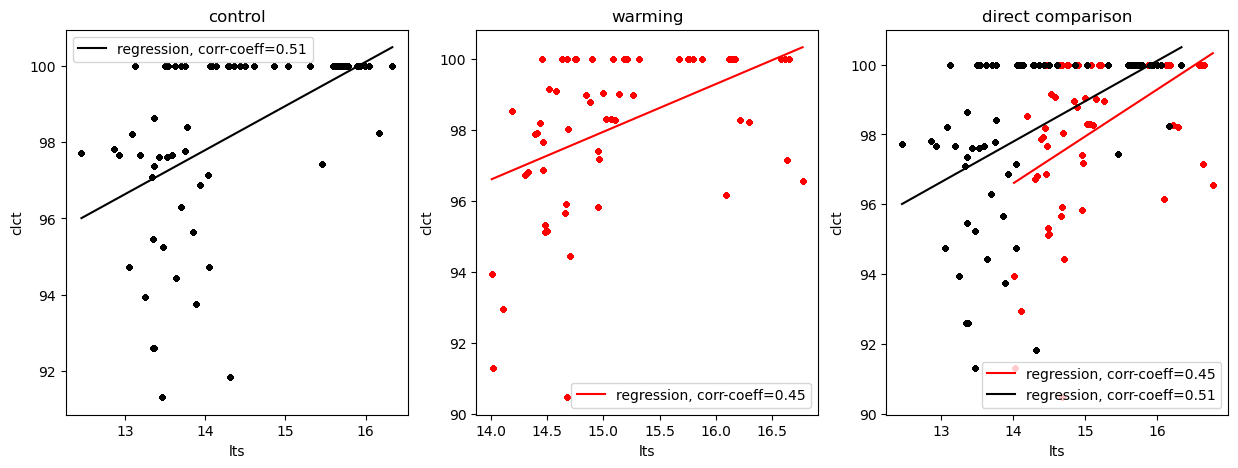

In [27]:
regression_plot(['lts', 'clct'])

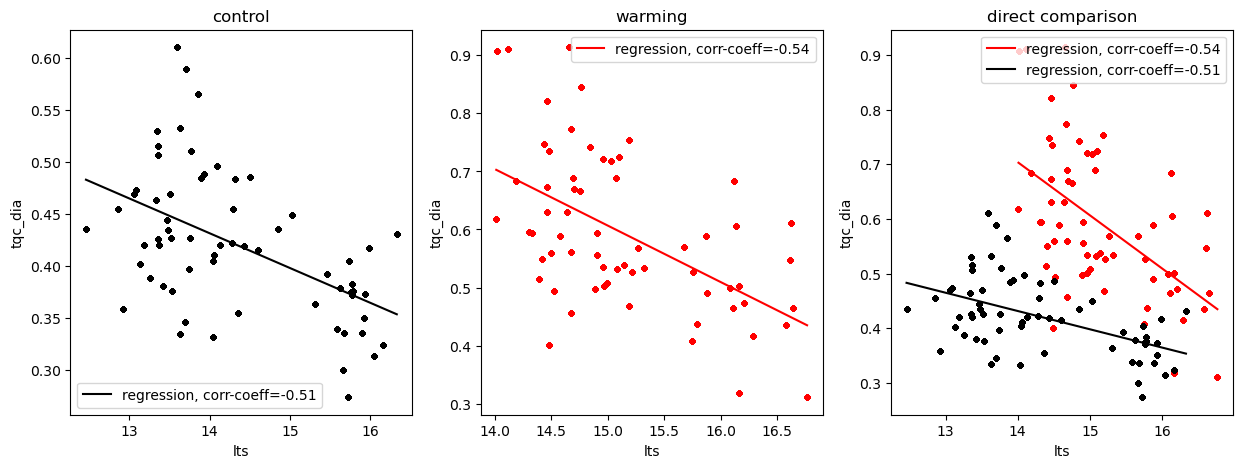

In [28]:
regression_plot(['lts', 'tqc_dia'])

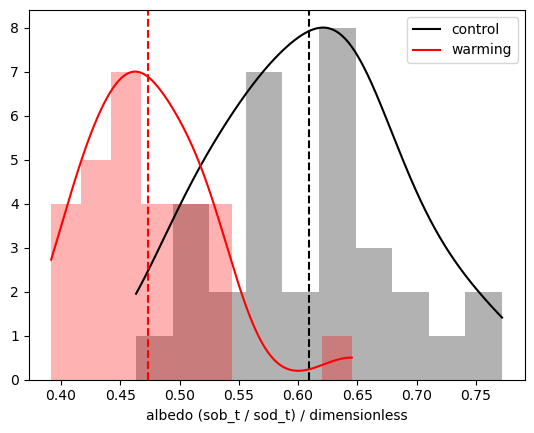

In [29]:
plot_hist_comparison('albedo')

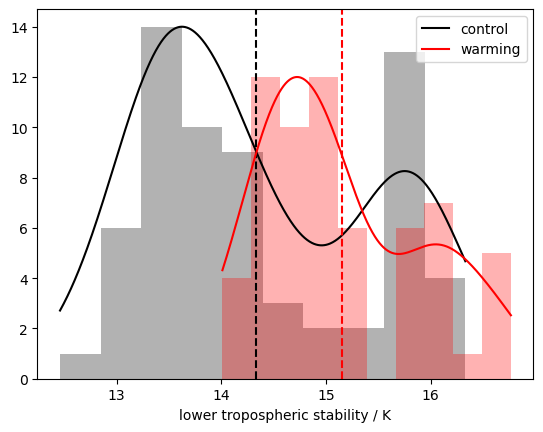

In [30]:
plot_hist_comparison('lts')

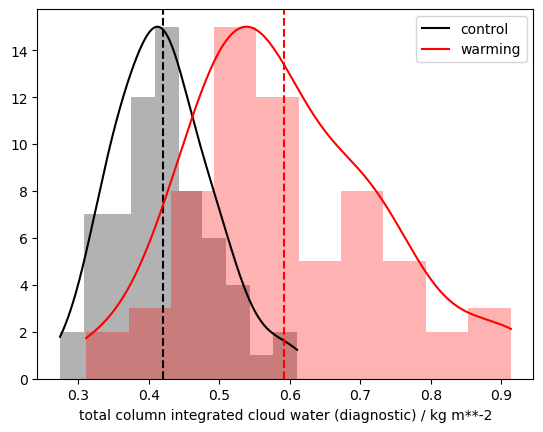

In [31]:
plot_hist_comparison('tqc_dia')

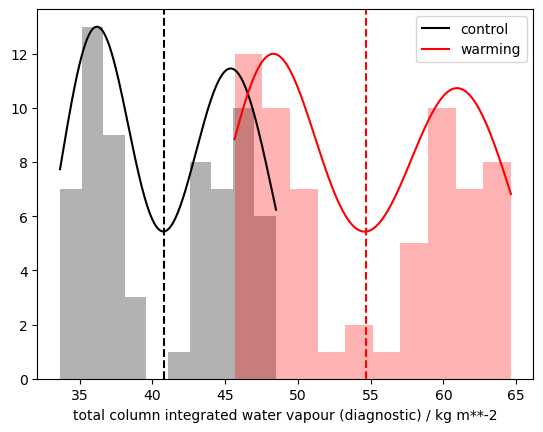

In [32]:
plot_hist_comparison('tqv_dia')

In [33]:
stop()

NameError: name 'stop' is not defined

In [ ]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import file_handling as fh
import postprocessing as pp
import calculations as cc
import xarray as xr
fh.disable_warnings()

def load_warm(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    datasets = list()
    
    file_list = fh.disk_data_from_keywords(exp_dir, ['3D', 'DOM01'], return_file_list=1)[10:20]
    data = xr.open_mfdataset(file_list, combine = 'nested', concat_dim="time")
    data = pp.clean_volume_data(data)
    datasets.append(data)
    
    file_list = fh.disk_data_from_keywords(exp_dir, ['radiation', 'DOM01'], return_file_list=1)
    data = xr.open_mfdataset(file_list, combine = 'nested', concat_dim="time")
    data = pp.clean_surface_data(data)
    datasets.append(data)
    
    file_list = fh.disk_data_from_keywords(exp_dir, ['surface', 'DOM01'], return_file_list=1)
    data = xr.open_mfdataset(file_list, combine = 'nested', concat_dim="time")
    data = pp.clean_surface_data(data)
    datasets.append(data)
    
    datasets = pp.time_overlap(datasets)
    data = xr.merge(datasets)
    return data
    
warm = load_warm()

In [ ]:
def load_ctrl():
    datasets = [fh.eureca_data_from_keywords(['3D', 'DOM01']), fh.eureca_data_from_keywords(['surface', 'DOM01']), fh.eureca_data_from_keywords(['radiation', 'DOM01'])]
    datasets = pp.time_overlap(datasets)
    data = xr.merge(datasets)
    # data, warm = pp.time_overlap([data, warm])
    return data
    
ctrl = load_ctrl()
ctrl, warm = pp.time_overlap([ctrl, warm])
ctrl

In [ ]:
def subsample(data, ncells=1000):
    data = pp.filter_by_threshold(data, {'tqi_dia':1e-4}, below_threshold=True, chunk_size=None)
    data = pp.filter_by_threshold(data, {'tqc_dia':1e-1}, below_threshold=False, chunk_size=None)
    data = pp.random_subsample(data, {'cell':ncells}).squeeze()
    data = calculate_metrics(data, drop_vars=False)
    data = pp.filter_by_threshold(data, {'cth':11}, below_threshold=False, chunk_size=None)
    return data

def calculate_metrics(data, drop_vars=True):
    data_vars = list(data)
    data = pp.replace_height_indices_with_values(data)
    data = cc.add_lifting_condensation_level_pressure(data)
    data = cc.add_lower_tropospheric_stability(data)
    data = cc.add_estimated_lapse_rate_stability(data)
    data = cc.add_cloud_top_height(data)
    data = data.compute()
    data['eis'] = data['lts'] - data['elrs']
    data['eis'].attrs['long_name'] = 'estimated inversion strenght'
    if drop_vars: data = data.drop_vars(data_vars)
    return data

ctrl, warm = pp.time_overlap([ctrl, warm])
# ctrl = subsample(ctrl)
# warm = subsample(warm)

In [ ]:
import xarray as xr

def remove_dimension(dataset: xr.Dataset, dim_name: str) -> xr.Dataset:
    """
    Remove all variables along a specified dimension from an xarray.Dataset and also remove the dimension itself.

    Parameters:
    ds (xarray.Dataset): The input xarray.Dataset from which variables and the dimension will be removed.
    dim_name (str): The name of the dimension to be removed along with all variables associated with it.

    Returns:
    xarray.Dataset: A new xarray.Dataset with the specified dimension and its associated variables removed.
    """
    vars_to_remove = [var for var in dataset.data_vars if dim_name in dataset[var].dims]
    dataset = dataset.drop_vars(vars_to_remove)
    dataset = dataset.drop_dims(dim_name)
    return dataset

In [ ]:
# print(list(remove_dimension(ctrl, 'height')))
# remove_dimension(ctrl, 'height')


In [ ]:
import matplotlib.pyplot as plt
import plot_utils as pu
import importlib; importlib.reload(pu)

variables = ['lts', 'tqc_dia', 'rh_2m']

fig, ax = plt.subplots(figsize=(20,15))
d = remove_dimension(ctrl, 'height')
ax = pu.ax_correlation_matrix(ax, d)
fig.show()

In [ ]:
import numpy as np

fig, ax = plt.subplots()
kwargs = [
    {'label':'control', 'color':'black'},
    {'label':'warming', 'color':'red'}
]
for dataset, kwargs in zip([ctrl, warm], kwargs):
    ax.hist(np.ravel(dataset['lts'].values), **kwargs)

ax.set_xlabel('LTS / K')
ax.legend()
fig.show()

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde


var = 'lts'

fig, ax = plt.subplots()
kwargs = [
    {'label': 'control', 'color': 'black'},
    {'label': 'warming', 'color': 'red'}
]

for dataset, kwarg in zip([ctrl, warm], kwargs):
    dataset = np.ravel(dataset[var].values)
    dataset = pp.drop_nan(dataset)
    kde = gaussian_kde(dataset)
    x = np.linspace(min(dataset), max(dataset), 1000)
    y = kde(x)
    
    # Plot the contour lines
    ax.plot(x, y, label=kwarg['label'], color=kwarg['color'])

ax.set_xlabel('LTS / K')
ax.legend()
fig.show()

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde


var = 'tqc_dia'

fig, ax = plt.subplots()
kwargs = [
    {'label': 'control', 'color': 'black'},
    {'label': 'warming', 'color': 'red'}
]

for dataset, kwarg in zip([ctrl, warm], kwargs):
    dataset = np.ravel(dataset[var].values)
    dataset = pp.drop_nan(dataset)
    kde = gaussian_kde(dataset)
    x = np.linspace(min(dataset), max(dataset), 1000)
    y = kde(x)
    ax.plot(x, y, label=kwarg['label'], color=kwarg['color'])

ax.set_xlabel(f'column integrated water vapour / $kg \\cdot m^{{-2}}$')
ax.legend()
fig.show()

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde


var = 'sou_t'

fig, ax = plt.subplots()
kwargs = [
    {'label': 'control', 'color': 'black'},
    {'label': 'warming', 'color': 'red'}
]

for dataset, kwarg in zip([ctrl, warm], kwargs):
    dataset = np.ravel(dataset[var].values)
    dataset = pp.drop_nan(dataset)
    kde = gaussian_kde(dataset)
    x = np.linspace(min(dataset), max(dataset), 1000)
    y = kde(x)
    ax.plot(x, y, label=kwarg['label'], color=kwarg['color'])

ax.set_xlabel(f'upwave shortwave flux / $W \\cdot m^{{-2}}$')
ax.legend()
fig.show()

In [ ]:
kwargs = [ {'color': 'black'}, {'color': 'red'} ]
fig, axs = plt.subplots(2,1, figsize=(6,12))
for ax, dataset, kwarg in zip(axs, [ctrl, warm], kwargs):
    pu.ax_variable_correlation(ax, dataset, ['lts', 'tqc_dia'], kwargs=kwarg)
fig.show()

In [ ]:
import matplotlib.pyplot as plt

def ax_plot_violin(ax, data_dict, kwargs={}, spacing=0.6):
    """
    Plots a violin plot of the variables in the given dictionary onto the provided Axes object,
    with markers for the mean of each distribution.

    Parameters:
    ax (matplotlib.axes.Axes): The Axes object on which to plot the violin plot.
    data_dict (dict): A dictionary where keys are strings representing the variable names and values are numpy.ndarrays representing the data for each variable.
    kwargs (dict, optional): Additional keyword arguments to pass to the violin plot function.
    spacing (float, optional): The spacing factor between the violins. Default is 0.8.

    Returns:
    matplotlib.axes.Axes: The Axes object with the violin plot.
    """
    data = [pp.drop_nan(data_dict[key]) for key in data_dict.keys()]
    labels = list(data_dict.keys())
    positions = np.arange(1, len(labels) + 1) * spacing
    
    parts = ax.violinplot(data, positions=positions, **kwargs)
    ax.set_xticks(positions)
    ax.set_xticklabels(labels)
    
    for i, d in enumerate(data):
        mean = np.mean(d)
        ax.scatter(positions[i], mean, color='tab:blue', marker='_', s=1000, zorder=3, **kwargs)
    return ax

fig, ax = plt.subplots(figsize=(4,6))
ax.set_title('cloud top height')
ax_plot_violin(ax, {'control':np.ravel(ctrl['cth'].values/1e3) , 'warming':np.ravel(warm['cth'].values/1e3)})
ax.set_ylabel('height / km')
fig.tight_layout()
fig.show()

In [ ]:
stop()

In [ ]:
ctrl

In [ ]:
dataset = pp.add_grid(ctrl).isel(time=-1)
print(dataset['tqc_dia'].dims, dataset['tqc_dia'].coords)
dataset

In [ ]:
import numpy as np
import xarray as xr

def bin_dataset(ds, lat_bins, lon_bins, varnames={'latitude':'lat', 'longitude':'lon', 'cell':'cell'}):
    # Define the bins for latitude and longitude
    lat_min, lat_max = ds[varnames["latitude"]].min().values, ds[varnames["latitude"]].max().values
    lon_min, lon_max = ds[varnames["longitude"]].min().values, ds[varnames["longitude"]].max().values
    lat_bin_edges = np.linspace(lat_min, lat_max, lat_bins + 1)
    lon_bin_edges = np.linspace(lon_min, lon_max, lon_bins + 1)

    # Calculate the midpoints of the bins to serve as labels
    lat_bin_midpoints = (lat_bin_edges[:-1] + lat_bin_edges[1:]) / 2
    lon_bin_midpoints = (lon_bin_edges[:-1] + lon_bin_edges[1:]) / 2
    lat_bin_indices = np.digitize(ds[varnames["latitude"]], lat_bin_edges) - 1
    lon_bin_indices = np.digitize(ds[varnames["longitude"]], lon_bin_edges) - 1
    lat_bin_indices = np.clip(lat_bin_indices, 0, lat_bins - 1)
    lon_bin_indices = np.clip(lon_bin_indices, 0, lon_bins - 1)

    # Create a new dataset to store binned data
    binned_ds = xr.Dataset(
        coords={
            'lat_binned': lat_bin_midpoints,
            'lon_binned': lon_bin_midpoints,
            'time': ds['time']
        }
    )

    # Bin each data variable
    for var in ds.data_vars:
        binned_data = np.zeros((lat_bins, lon_bins))
        for i in range(lat_bins):
            for j in range(lon_bins):
                mask = (lat_bin_indices == i) & (lon_bin_indices == j)
                mask_da = xr.DataArray(mask, dims=['cell'], coords={'cell': ds[varnames["latitude"]].coords['cell']})
                if mask_da.any():
                    mean_value = ds[var].where(mask_da, drop=True).mean(dim='cell').values
                    if mean_value.size == 1:
                        binned_data[i, j] = mean_value.item()
                    else:
                        binned_data[i, j] = np.nan  # Handle cases where mean_value is not a scalar
        
        binned_ds[var] = xr.DataArray(
            binned_data,
            coords={
                'lat_binned': lat_bin_midpoints,
                'lon_binned': lon_bin_midpoints
            },
            dims=['lat_binned', 'lon_binned']
        )

    return binned_ds

In [ ]:
def subsample(data, ncells=100):
    # data = pp.filter_by_threshold(data, {'tqi_dia':1e-4}, below_threshold=True, chunk_size=None)
    # data = pp.filter_by_threshold(data, {'tqc_dia':1e-1}, below_threshold=False, chunk_size=None)
    data = pp.random_subsample(data, {'cell':ncells}).squeeze()
    # data = calculate_metrics(data, drop_vars=False)
    # data = pp.filter_by_threshold(data, {'cth':11}, below_threshold=False, chunk_size=None)
    return data

subsample = subsample(dataset.drop_vars('height_bnds'), 100)
subsample = bin_dataset(subsample, 20, 10)
print(subsample)

In [ ]:
subsample.tqc_dia.plot()

In [ ]:
stop()

In [ ]:
import numpy as np
import xarray as xr

def bin_dataset(ds, lat_bins, lon_bins, varnames={'latitude':'lat', 'longitude':'lon', 'cell':'cell'}):
    # Define the bins for latitude and longitude
    lat_min, lat_max = ds[varnames["latitude"]].min().values, ds[varnames["latitude"]].max().values
    lon_min, lon_max = ds[varnames["longitude"]].min().values, ds[varnames["longitude"]].max().values
    lat_bin_edges = np.linspace(lat_min, lat_max, lat_bins + 1)
    lon_bin_edges = np.linspace(lon_min, lon_max, lon_bins + 1)

    # Calculate the midpoints of the bins to serve as labels
    lat_bin_midpoints = (lat_bin_edges[:-1] + lat_bin_edges[1:]) / 2
    lon_bin_midpoints = (lon_bin_edges[:-1] + lon_bin_edges[1:]) / 2

    # Create a new dataset to store binned data
    binned_ds = xr.Dataset(
        coords={
            'lat_binned': lat_bin_midpoints,
            'lon_binned': lon_bin_midpoints,
            'time': ds['time']
        }
    )

    # Bin each data variable
    for var in ds.data_vars:
        # Use groupby_bins to bin the data by latitude
        lat_grouped = ds[var].groupby_bins(ds[varnames["latitude"]], lat_bin_edges).mean(dim=varnames['cell'])

        # Initialize an array to store the final binned data
        binned_data = np.full((lat_bins, lon_bins), np.nan)

        # Iterate over latitude bins
        for i, lat_bin in enumerate(lat_grouped.lat_bins.values):
            # For each latitude bin, further bin by longitude
            lon_grouped = lat_grouped.sel(lat_bins=lat_bin).groupby_bins(ds[varnames["longitude"]], lon_bin_edges).mean(dim=varnames['cell'])

            # Fill the binned_data array
            for j, lon_bin in enumerate(lon_grouped.lon_bins.values):
                if not lon_grouped.sel(lon_bins=lon_bin).isnull().all():
                    binned_data[i, j] = lon_grouped.sel(lon_bins=lon_bin).values

        # Add the binned data to the new dataset
        binned_ds[var] = xr.DataArray(
            binned_data,
            coords={
                'lat_binned': lat_bin_midpoints,
                'lon_binned': lon_bin_midpoints
            },
            dims=['lat_binned', 'lon_binned']
        )

    return binned_ds

In [ ]:
def subsample_dataset(data, ncells=100):
    # data = pp.filter_by_threshold(data, {'tqi_dia':1e-4}, below_threshold=True, chunk_size=None)
    # data = pp.filter_by_threshold(data, {'tqc_dia':1e-1}, below_threshold=False, chunk_size=None)
    data = pp.random_subsample(data, {'cell':'ncells'}).squeeze()
    # data = calculate_metrics(data, drop_vars=False)
    # data = pp.filter_by_threshold(data, {'cth':11}, below_threshold=False, chunk_size=None)
    return data
    
subsample2 = subsample_dataset(dataset.drop_vars('height_bnds'))
# subsample2
subsample2 = bin_dataset(subsample2, 20, 10)
subsample2.tqc_dia.plot()

In [ ]:
stop()

In [ ]:
import numpy as np
import xarray as xr

def bin_dataset(ds, lat_bins, lon_bins, varnames={'latitude':'lat', 'longitude':'lon'}):
    # Define the bins for latitude and longitude
    lat_min, lat_max = ds[varnames["latitude"]].min().item(), ds[varnames["latitude"]].max().item()
    lon_min, lon_max = ds[varnames["longitude"]].min().item(), ds[varnames["longitude"]].max().item()
    lat_bin_edges = np.linspace(lat_min, lat_max, lat_bins + 1)
    lon_bin_edges = np.linspace(lon_min, lon_max, lon_bins + 1)

    # Calculate the midpoints of the bins to serve as labels
    lat_bin_midpoints = (lat_bin_edges[:-1] + lat_bin_edges[1:]) / 2
    lon_bin_midpoints = (lon_bin_edges[:-1] + lon_bin_edges[1:]) / 2

    # Group by the latitude and longitude bins and calculate the mean for each bin
    binned_ds = ds.groupby_bins(varnames["latitude"], lat_bin_edges).mean(dim=varnames["latitude"])
    binned_ds = binned_ds.groupby_bins(varnames["longitude"], lon_bin_edges).mean(dim=varnames["longitude"])

    # Rename the bin coordinates to match the midpoints
    binned_ds = binned_ds.rename({
        f'{varnames["latitude"]}_bins': 'lat_binned',
        f'{varnames["longitude"]}_bins': 'lon_binned'
    })
    binned_ds['lat_binned'] = lat_bin_midpoints
    binned_ds['lon_binned'] = lon_bin_midpoints

    return binned_ds

dataset2 = pp.add_grid(ctrl).isel(time=-1)
dataset2 = bin_dataset(dataset2, 20, 10)
dataset2

In [ ]:
stop()

In [ ]:
def subsample(data, ncells=1000):
    data = pp.filter_by_threshold(data, {'tqi_dia':1e-4}, below_threshold=True, chunk_size=None)
    data = pp.filter_by_threshold(data, {'tqc_dia':1e-1}, below_threshold=False, chunk_size=None)
    data = pp.random_subsample(data, {'cell':ncells}).squeeze()
    data = calculate_metrics(data, drop_vars=False)
    data = pp.filter_by_threshold(data, {'cth':11}, below_threshold=False, chunk_size=None)
    return data

def calculate_metrics(data, drop_vars=True):
    data_vars = list(data)
    data = pp.replace_height_indices_with_values(data)
    data = cc.add_lifting_condensation_level_pressure(data)
    data = cc.add_lower_tropospheric_stability(data)
    data = cc.add_estimated_lapse_rate_stability(data)
    data = cc.add_cloud_top_height(data)
    data = data.compute()
    data['eis'] = data['lts'] - data['elrs']
    data['eis'].attrs['long_name'] = 'estimated inversion strenght'
    if drop_vars: data = data.drop_vars(data_vars)
    return data

ctrl, warm = pp.time_overlap([ctrl, warm])
ctrl = subsample(ctrl)
warm = subsample(warm)

In [ ]:
stop()

In [ ]:
# stop()

In [ ]:
import matplotlib.pyplot as plt
import plot_utils as pu

fig, ax = plt.subplots(figsize=(4,8))

for f in fh.disk_data_from_keywords('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/', ['DOM01', '3D'], return_file_list=1)[::12]:
    d = xr.open_dataset(f)
    d = pp.replace_height_indices_with_values(d)
    try:
        x = d.isel({'time':0, 'ncells':2343987})['pres'].values
        y = d.isel({'time':0, 'ncells':2343987})['height'].values
        ax.plot(x,y, color='black', alpha =0.6, lw=0.1)
    except: pass
        
ax.set_xlabel('pressure / Pa')
ax.set_ylabel('height / m')
ax.set_ylim(0, None)
ax = pu.remove_spines(ax, ['left', 'right', 'top'])
fig.show()

In [ ]:
# ctrl.sel(height=1500, method='nearest')

In [ ]:
# stop()

In [ ]:
# def find_index_of_nearest_value(data_array, target_value, search_dim):
#     """
#     Finds the indices along a specified dimension where the values in the DataArray
#     are closest to a given target value for each combination of other dimensions.

#     Args:
#         data_array (xarray.DataArray): The input DataArray containing the target variable.
#         target_value (float): The target value to find the closest elements in the variable.
#         search_dim (str): The name of the dimension along which to search for the nearest values.

#     Returns:
#         xarray.DataArray: A DataArray with dimensions corresponding to the data_array excluding the
#                           search dimension, containing the indices where the variable values
#                           are closest to the target value along the search dimension. Indices for all-NaN
#                           slices will be set to NaN.

#     Raises:
#         ValueError: If the specified search dimension is not found in the DataArray.
#     """
#     if search_dim not in data_array.dims:
#         raise ValueError(f"Search dimension '{search_dim}' not found in DataArray dimensions")

#     abs_diff = abs(data_array - target_value)
#     min_diff_index = abs_diff.argmin(dim=search_dim, skipna=True)
#     is_all_nan = abs_diff.isnull().all(dim=search_dim)
#     min_diff_index = min_diff_index.where(~is_all_nan, np.nan)

#     return min_diff_index

# d = fh.disk_data_from_keywords('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/', ['DOM01', '3D'])
# find_index_of_nearest_value(d['pres'], 85000, 'height').mean(dim=['ncells'], skipna=True).values

In [ ]:
subsampled =  [subsample(pp.add_grid(d), 100) for d in [ctrl, warm]]

In [ ]:
print(subsampled[0])

In [ ]:
dataset = subsampled[0]

In [ ]:
import xarray as xr
import numpy as np

def split_and_average_to_grid(dataset, num_lat_splits, num_lon_splits):
    # Step 1: Identify the split points for latitude and longitude
    lat_split_points = np.linspace(dataset['lat'].min().compute().item(), dataset['lat'].max().compute().item(), num_lat_splits + 1)
    lon_split_points = np.linspace(dataset['lon'].min().compute().item(), dataset['lon'].max().compute().item(), num_lon_splits + 1)
    
    # Step 2: Initialize dictionaries to store the means and coordinates
    grid_means = {var: np.empty((num_lat_splits, num_lon_splits)) for var in dataset.data_vars}
    grid_lats = np.empty((num_lat_splits, num_lon_splits))
    grid_lons = np.empty((num_lat_splits, num_lon_splits))
    
    # Step 3: Loop over each region and compute the mean
    for i in range(num_lat_splits):
        for j in range(num_lon_splits):
            lat_mask = (dataset['lat'] >= lat_split_points[i]) & (dataset['lat'] < lat_split_points[i + 1])
            lon_mask = (dataset['lon'] >= lon_split_points[j]) & (dataset['lon'] < lon_split_points[j + 1])
            region_mask = lat_mask & lon_mask
            
            # Apply the mask to create a subset for the current region
            region_dataset = dataset.where(region_mask, drop=True)
            
            # Compute the mean for each variable in the current region
            for var in dataset.data_vars:
                # Determine the dimensions to average over
                dims_to_average = [dim for dim in region_dataset[var].dims if dim != 'cell']
                mean_value = region_dataset[var].mean(dim=dims_to_average).compute()
                if mean_value.size == 1:
                    grid_means[var][i, j] = mean_value.item()
                else:
                    grid_means[var][i, j] = np.nan  # Handle cases where mean does not reduce to a single value
            
            # Calculate the average lat and lon for the region
            avg_lat = region_dataset['lat'].mean().compute().item()
            avg_lon = region_dataset['lon'].mean().compute().item()
            
            # Store the coordinates
            grid_lats[i, j] = avg_lat
            grid_lons[i, j] = avg_lon
    
    # Step 4: Ensure unique and sorted coordinates
    unique_lats = np.sort(np.unique(grid_lats.flatten()))
    unique_lons = np.sort(np.unique(grid_lons.flatten()))
    
    # Step 5: Create a new dataset with lat and lon as dimensions
    grid_dataset = xr.Dataset(
        {var: (['lat', 'lon'], grid_means[var]) for var in dataset.data_vars},
        coords={
            'lat': (['lat'], unique_lats),
            'lon': (['lon'], unique_lons)
        }
    )
    
    return grid_dataset

# Example usage
num_lat_splits = 2
num_lon_splits = 2
grid_dataset = split_and_average_to_grid(dataset, num_lat_splits, num_lon_splits)

# Print the results
print(grid_dataset)

In [ ]:
import matplotlib.pyplot as plt

def plot_region_means(dataset, variable_name):
    # Extract the data
    data = dataset[variable_name].values
    avg_lats = dataset['avg_lat'].values
    avg_lons = dataset['avg_lon'].values
    
    # Reshape the data to match the number of latitude and longitude splits
    num_lat_splits = len(np.unique(avg_lats))
    num_lon_splits = len(np.unique(avg_lons))
    print(dataset.dims)
    print(dataset.coords)
    print(num_lat_splits, num_lon_splits)
    data_reshaped = data.reshape((num_lat_splits, num_lon_splits))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    cax = ax.imshow(data_reshaped, origin='lower', aspect='auto', extent=[avg_lons.min(), avg_lons.max(), avg_lats.min(), avg_lats.max()], cmap='viridis')
    
    # Add colorbar
    cbar = fig.colorbar(cax, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
    cbar.set_label(f'{variable_name} mean')
    
    # Set axis labels
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Set title
    ax.set_title(f'Mean {variable_name} by Region')
    
    plt.show()

# Example usage
plot_region_means(quadrant_means, 'cth')

In [ ]:
import matplotlib.pyplot as plt 
import plot_utils as pu
import numpy as np
import importlib; importlib.reload(pu)

keep_vars = ['sou_t', 'lts', 'cth', 'tqc_dia', 'clct']

upper = True
for data, label in zip(subsampled, ['ctrl', 'warm']):
    print('clct' in list(data))
    fig, ax = plt.subplots()
    del_vars  = [v for v in list(data) if not v in keep_vars]
    dataset = data.drop_vars(del_vars).drop_dims('height')
    ax = pu.ax_correlation_matrix(ax, dataset, cmap='bwr', add_cbar=upper)
    if upper: ax = pu.remove_ticks(ax,['bottom', 'right']); upper = False
    ax.set_title(label)
plt.show()

In [ ]:
import matplotlib.pyplot as plt 
import plot_utils as pu
import numpy as np
import importlib; importlib.reload(pu)

keep_vars = ['sou_t', 'lts', 'elrs', 'cth', 'tqc_dia', 'clct', 'rh_2m', 't_seasfc']

upper = True
for data, label in zip([ctrl, warm], ['ctrl', 'warm']):
    fig, ax = plt.subplots()
    del_vars  = [v for v in list(data) if not v in keep_vars]
    dataset = data.drop_vars(del_vars).drop_dims('height')
    ax = pu.ax_correlation_matrix(ax, dataset, cmap='bwr', add_cbar=upper)
    if upper: ax = pu.remove_ticks(ax,['bottom', 'right']); upper = False
    ax.set_title(label)
plt.show()


# import matplotlib.pyplot as plt 
# import plot_utils as pu
# import importlib; importlib.reload(pu)
# import numpy as np

# keep_vars = ['sou_t', 'lts', 'elrs', 'cth', 'tqc_dia', 'clct', 'rh_2m', 't_seasfc'  ]
# del_vars  = [v for v in list(data) if not v in keep_vars]
# dataset = data.drop_vars(del_vars).drop_dims('height')
# dataset['EIS'] = dataset['lts'] - dataset['elrs']
# dataset['EIS'].attrs['long_name'] = 'estimated inversion strenght'

# fig, ax = plt.subplots()
# ax = pu.ax_correlation_matrix(ax, dataset, cmap='bwr')
# fig.show()

In [ ]:
keep_vars = ['sou_t', 'lts', 'elrs', 'ctl', 'tqc_dia', 'clct', 'rh_2m', 't_seasfc', 'lcl_pres']

fig, axs = plt.subplots(1,2, figsize=(10,5))
for ax, data, kwargs in zip(axs,[ctrl,warm], [{'color':'black'}, {'color':'red'}]):
    del_vars  = [v for v in list(data) if not v in keep_vars]
    dataset = data.drop_vars(del_vars).drop_dims('height')
    axs[0] = pu.ax_variable_correlation(axs[0], dataset, ['lcl_pres', 'elrs'], kwargs=kwargs)
    axs[1] = pu.ax_variable_correlation(axs[1], dataset, ['lcl_pres', 'rh_2m'], kwargs=kwargs)

fig.tight_layout()
fig.show()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
for ax, data, kwargs in zip(axs,[ctrl,warm], [{'color':'black'}, {'color':'red'}]):
    del_vars  = [v for v in list(data) if not v in keep_vars]
    dataset = data.drop_vars(del_vars).drop_dims('height')
    axs[0] = pu.ax_variable_correlation(axs[0], dataset, ['lts', 'elrs'], kwargs=kwargs)
    axs[1] = pu.ax_variable_correlation(axs[1], dataset, ['lts', 'tqc_dia'], kwargs=kwargs)

fig.tight_layout()
fig.show()

In [ ]:
keep_vars = ['sou_t', 'lts', 'elrs', 'cth', 'tqc_dia', 'clct', 'rh_2m', 't_seasfc', 'lcl_pres']

fig, axs = plt.subplots(*pu.isqrt(len(list(dataset))), figsize=(20,10))

for data, kwargs in zip([ctrl, warm], [{'color':'black'}, {'color':'red'}]):
    del_vars  = [v for v in list(data) if not v in keep_vars]
    dataset = data.drop_vars(del_vars).drop_dims('height')
    # print(sorted(list(dataset)))
    for var, ax in zip(sorted(list(dataset)), np.ravel(axs)):
        d = np.ravel(dataset[var].values)
        ax.hist(d, bins=20, **kwargs)
        ax.set_xlabel(var)
fig.tight_layout()
fig.show()

In [ ]:
def ax_profiles_with_average(ax, dataarray, color='black'):
    """
    Plots all atmospheric temperature profiles in gray and the average profile in red.
    
    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - dataarray (xr.DataArray): The DataArray containing the temperature profiles with dimensions ('time', 'cell', 'height').
    
    Returns:
    - ax (matplotlib.axes.Axes): The Axes object with the plots added.
    """
    height = pp.replace_height_indices_with_values(dataarray)['height']
    mean_profile = dataarray.mean(dim=['time', 'cell'])

    for t in range(dataarray.sizes['time']):
        for c in range(dataarray.sizes['cell']):
            ax.plot(dataarray.isel(time=t, cell=c), height, color=color, alpha=0.1)
    ax.plot(mean_profile, height, color=color, linewidth=2, label='Average Profile', zorder=3)

    ax.set_xlabel('virtual potential temperature / h')
    ax.set_ylabel('height / m')
    ax.set_ylim(0,None)
    return ax

fig, ax = plt.subplots( figsize=(5,10))
ax = ax_profiles_with_average(ax, cc.add_prognostic_variables(ctrl)['theta'])
ax = ax_profiles_with_average(ax, cc.add_prognostic_variables(warm)['theta'], color='tab:red')
fig.tight_layout()
fig.show()